# Skincancer HAM-dataset med Pytorch, multiple inputs

### Standardimporter

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
import torch.optim as optim
from torch.optim import lr_scheduler
import os

import numpy as np
import pandas as pd
#from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

### Definiera de olika mängderna för träning, validering och test:

In [10]:
batchsz = 4

# Definiera vilken augmentation som ska göras:
train_data_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

val_test_data_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

basepath = "../../../ml/Datasets/skin-cancer-mnist-ham10000/"
image_path = "images_per_label_splitted_sets/"
csv_path = "csv/"

# Definiera de tre dataseten:
skincancer_train_dataset = datasets.ImageFolder(root = basepath + image_path + '/train/',
                                           transform = train_data_transform)

skincancer_valid_dataset = datasets.ImageFolder(root = basepath + image_path + '/val/',
                                           transform = val_test_data_transform)

skincancer_test_dataset = datasets.ImageFolder(root = basepath + image_path + '/test/',
                                              transform = val_test_data_transform)

# Skapa loaders för de tre dataseten:
train_loader = torch.utils.data.DataLoader(skincancer_train_dataset,
                                             batch_size = batchsz, shuffle = True,
                                             num_workers = 4)

valid_loader = torch.utils.data.DataLoader(skincancer_valid_dataset,
                                             batch_size = batchsz, shuffle = True,
                                             num_workers = 4)

test_loader = torch.utils.data.DataLoader(skincancer_test_dataset,
                                             batch_size = batchsz, shuffle = False,
                                             num_workers = 4)

In [14]:
# Importera ytterligare data från csv-filen:

ham_df_all = pd.read_csv(basepath + csv_path + "HAM10000_metadata.csv")

In [18]:
ham_df_all

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face


In [16]:
ham_df = ham_df_all[[ 'age', 'sex', 'localization' ]]

In [17]:
ham_df.head(n = 3)

,age,sex,localization
0,80.0,male,scalp
1,80.0,male,scalp
2,80.0,male,scalp


### Create code for moving to GPU, if available

In [3]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [4]:
device = get_default_device()

In [5]:
print(device)

cuda


### De båda nedanstående blocken används för att enkelt flytta till GPU: 

In [6]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [7]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

### Flytta train_loader och test_loader till GPU:n

In [8]:
train_dl = DeviceDataLoader(train_loader, device)
valid_dl = DeviceDataLoader(valid_loader, device)
test_dl = DeviceDataLoader(test_loader, device)

In [9]:
train_dl.device

device(type='cuda')

In [10]:
valid_dl.device

device(type='cuda')

In [11]:
test_dl.device

device(type='cuda')

In [46]:
targets = train_loader.dataset.targets
print(len(targets))

7007


### Examine a batch of images

In [12]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [13]:
# Get a batch of training data
images, classes = next(iter(train_loader))
class_names = train_loader.dataset.classes

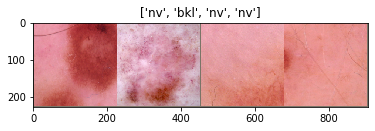

In [14]:
# Make a grid from batch
out = torchvision.utils.make_grid(images)

imshow(out, title = [class_names[x] for x in classes])

In [15]:
# Visa dimensionerna för en bild-tensor (batchsize, number of channels, width, height):
images.shape

torch.Size([4, 3, 224, 224])

#### Hur blir tensor-storlekarna när de flödar genom ett eget CNN-nät?

In [16]:
# Hämta en batch med bilder:

for x, labels in train_loader:
    print("Ursprunglig storlek: ", x.shape)
    break

Ursprunglig storlek:  torch.Size([4, 3, 224, 224])


In [17]:
x = nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 5, stride = 2)(x)
print("Efter Conv2d(1, 3, 5, 2): ", x.shape)

Efter Conv2d(1, 3, 5, 2):  torch.Size([4, 16, 110, 110])


In [18]:
x = nn.MaxPool2d(kernel_size = 2, stride = 2)(x)
print("Efter Pooling, kernel_size = 2, stride = 2 så blir storleken: ", x.shape)

Efter Pooling, kernel_size = 2, stride = 2 så blir storleken:  torch.Size([4, 16, 55, 55])


In [19]:
x = nn.Conv2d(in_channels = 16, out_channels = 64, kernel_size = 5, stride = 2)(x)
print(x.shape)

torch.Size([4, 64, 26, 26])


In [20]:
x = nn.MaxPool2d(kernel_size = 2, stride = 2)(x)
print("Efter Pooling, kernel_size = 2, stride = 2 så blir storleken: ", x.shape)

Efter Pooling, kernel_size = 2, stride = 2 så blir storleken:  torch.Size([4, 64, 13, 13])


In [21]:
x = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, stride = 2)(x)
print(x.shape)

torch.Size([4, 128, 6, 6])


In [22]:
x = nn.MaxPool2d(kernel_size = 2, stride = 2)(x)
print("Efter Pooling, kernel_size = 2, stride = 2 så blir storleken: ", x.shape)

Efter Pooling, kernel_size = 2, stride = 2 så blir storleken:  torch.Size([4, 128, 3, 3])


In [23]:
# Fånga automatiskt tensorn från CNN-delen som ska 
# formas om till en vektor:

x.view(-1, x.shape[1]*x.shape[2]*x.shape[3]).shape

torch.Size([4, 1152])

### Bygg ett eget CNN-nät:

In [24]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 5, stride = 2)
        self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 64, kernel_size = 5, stride = 2)
        self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, stride = 2)
        self.fc1 = nn.Linear(in_features = 128*3*3, out_features = 200)
        self.fc2 = nn.Linear(in_features = 200, out_features = 100)
        self.fc3 = nn.Linear(in_features = 100, out_features = 7)

    def forward(self, X):
        #
        # Första blocket CNN:
        X = F.relu(self.conv1(X))
        X = nn.MaxPool2d(kernel_size = 2, stride = 2)(X)
        #
        # Andra blocket CNN:
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, kernel_size = 2, stride = 2)
        #
        # Tredje blocket CNN:
        X = F.relu(self.conv3(X))
        X = nn.MaxPool2d(kernel_size = 2, stride = 2)(X)
        #
        # Flatten tensors to fully connected layers:
        X = X.view(-1, X.shape[1]*X.shape[2]*X.shape[3])
        X = F.relu(self.fc1(X))
        X = nn.Dropout(0.2)(X)
        X = F.relu(self.fc2(X))
        X = nn.Dropout(0.2)(X)
        X = self.fc3(X)
        return F.log_softmax(X, dim = 1)

In [25]:
torch.manual_seed(17)
model = ConvolutionalNetwork()

In [26]:
trainableparameters = []
for param in model.parameters():
    # trainableparameters = param.numel()
    trainableparameters.append(param.numel())

print("Antalet träningsbara parametrar är =", np.sum(trainableparameters), "st.")


Antalet träningsbara parametrar är = 352143 st.


In [29]:
model.fc3.out_features

7

### Flytta modellen till GPU, om en sådan finns:

In [72]:
# Flytta modellen till GPU:

to_device(model, device)

ConvolutionalNetwork(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2))
  (conv2): Conv2d(16, 64, kernel_size=(5, 5), stride=(2, 2))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
  (fc1): Linear(in_features=1152, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=7, bias=True)
)

In [73]:
# Verifiera att modellen är på rätt device:
# True => modellen finns på GPU.

next(model.parameters()).is_cuda

True

### Define loss function & optimizer

In [74]:
# Definiera loss-function och vilken optimerare som ska användas:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

### Look at one batch and on which device it is run

In [75]:
for X_train, y_train in train_dl:
    print('X_train.device:', X_train.device)
    print('y_train.device:', y_train.device)
    break

X_train.device: cuda:0
y_train.device: cuda:0


In [76]:
for X_valid, y_valid in valid_dl:
    print('X_valid.device:', X_valid.device)
    print('y_valid.device:', y_valid.device)
    break

X_valid.device: cuda:0
y_valid.device: cuda:0


In [77]:
for X_test, y_test in test_dl:
    print('X_test.device:', X_test.device)
    print('y_test.device:', y_test.device)
    break

X_test.device: cuda:0
y_test.device: cuda:0


### Trainingloop:

In [78]:
import time
start_training_time = time.time()

epochs = 2

no_training_images = len(train_loader.dataset) # = 7007

train_accuracy = []
train_losses = []

for epoch in range(epochs):
    start_epoch_time = time.time()
    train_correct_pred_per_epoch = 0
    
    # Antal iterationer i for-loopen = 7007/16 = 438 st. dvs 
    # antalet bilder i träningssetet delat med batch_size!
    for X_train, y_train in train_dl:
        y_train_pred = model.forward(X_train)
        train_loss = criterion(y_train_pred, y_train)
        
        # Beräkna statistik från träningen på träningsmängden:
        train_predicted = torch.max(y_train_pred.data, 1)[1]
        train_is_correct = (train_predicted == y_train).sum()
        train_correct_pred_per_epoch += train_is_correct
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
    
    # För träningsmängden:
    # Lagra accuracy och loss per epok för t.ex. plottning:
    train_epoch_accuracy = train_correct_pred_per_epoch.item() / no_training_images
    train_accuracy.append(train_epoch_accuracy)
    train_losses.append(train_loss)
    
    end_epoch_time = time.time()
    epoch_time = end_epoch_time - start_epoch_time
    # epoch startar på 0, därav "+1" nedan:
    print(f"Epok {epoch+1:02}, {epoch_time:2.2f} sek.: Träning: accuracy = {train_epoch_accuracy:4.4f} och loss är = {train_loss:4.4f}")
    
end_training_time = time.time()

delta = end_training_time - start_training_time

print(f'\nTraining took {delta/60:.2f} minutes.')    

Epok 01, 42.30 sek.: Träning: accuracy = 0.6685 och loss är = 1.0099
Epok 02, 36.92 sek.: Träning: accuracy = 0.6690 och loss är = 0.9425

Training took 1.32 minutes.


### Utvärdera på valideringsmängden:

In [53]:
model.eval()

valid_correct_pred_per_epoch = 0
valid_accuracy = []
valid_losses = []

no_valid_images = len(valid_loader.dataset) # = 998
with torch.no_grad():
    # Antal iterationer = 998 / 16 = 63 st.
    for X_valid, y_valid in valid_dl:

        y_valid_pred = model.forward(X_valid)
        
        valid_predicted = torch.max(y_valid_pred.data, 1)[1]
        valid_is_correct = (valid_predicted == y_valid).sum()
        valid_correct_pred_per_epoch += valid_is_correct
        
        valid_loss = criterion(y_valid_pred, y_valid)
        valid_losses.append(valid_loss.item())
            
        valid_epoch_accuracy = valid_correct_pred_per_epoch.item() / no_valid_images
        valid_accuracy.append(valid_epoch_accuracy)
        
# epoch startar på 0, därav "+1" nedan:
print(f"Validering: accuracy = {valid_epoch_accuracy:4.4f} och loss är = {valid_loss:4.4f}")

Validering: accuracy = 0.6713 och loss är = 1.5381


### Plotta accuracy och loss:

In [ ]:
max_loss = np.max(train_losses).item()
max_accuracy = np.max(train_accuracy).item()
y_max = 1.1*max(max_loss, max_accuracy)

plt.plot(range(epochs), train_accuracy)
plt.plot(range(epochs), train_losses)
plt.title("Accuracy and loss per epoch on the train set")
plt.legend(['Accuracy', 'Loss'], loc='lower left')
plt.yticks(np.arange(0, y_max, step = 0.2))
plt.ylim(0, y_max)
plt.show()

In [ ]:
max_loss = np.max(valid_losses).item()
max_accuracy = np.max(valid_accuracy).item()
y_max = 1.1*max(max_loss, max_accuracy)

plt.plot(range(len(valid_losses)), valid_accuracy)
plt.plot(range(len(valid_losses)), valid_losses)
plt.title("Accuracy and loss on the validation set")
plt.legend(['Accuracy', 'Loss'], loc='upper left')
plt.yticks(np.arange(0, y_max, step = 0.2))
plt.ylim(0, y_max)
plt.show()

### Evaluate the model on the test-set

In [ ]:
model.eval()

no_test_images = len(test_loader.dataset)

with torch.no_grad():
    correct = 0
    # Antal iterationer = 2010 / 16 = 123 st.
    for X_test, y_test in test_dl:
        y_pred_test = model.forward(X_test)
        predicted = torch.max(input = y_pred_test, dim = 1)[1]
        correct += (predicted == y_test).sum()
        
print(f'Test accuracy: {correct.item()}/{no_test_images} = {correct.item()*100/(no_test_images):5.2f} %')

### Visualisera modellens förutsägelser

In [ ]:
def visualize_model(model, num_images = 6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode = was_training)
                    return
        model.train(mode = was_training)

In [ ]:
visualize_model(model, 4)

### Batch-wise training loop:

In [ ]:
import time
start_time = time.time()

epochs = 16

no_training_images = len(dataset_trainloader.dataset) # 7007

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for epoch in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for currentbatch, (X_train, y_train) in enumerate(train_dl):
        currentbatch += 1
        
        # Apply the model
        y_pred_train = model(X_train)  # we don't flatten X-train here
        loss = criterion(y_pred_train, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred_train.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if currentbatch % 100 == 0:
            print(f'epoch: {epoch:2}  batch: {currentbatch:4} [{batchsz*currentbatch:4}/{no_training_images}]\
            loss: {loss.item():5.4f}\
            accuracy: {trn_corr.item()*100/(batchsz*currentbatch):5.1f} %')
        
    train_losses.append(loss)
    train_correct.append(trn_corr)

print(f'\nTraining took: {time.time() - start_time:.0f} seconds.') # print the time elapsed    